# Data Preprocessing & Parameter Initialization

Data pre-processing invovles converting raw data into clean, structured format suitable for analysis and deep learning models. 

**The need for data-processing**
1. Imporves Model Performace
   - Ensures models are trained on high-quality data, reducing (unwanted) noise, improving convergence and imporving accuracy.
2. Standardize Input Features:
   - Scaling ensures all features contrinute equally, preventing bias toward larger-scaled vairables (i.e. wieght in KG and Hight in M)


# Data Preprocessing

## Zero-Centering Data

**Given:** $\mathbf{X} \in \mathbb{R}^{n \times d}$ (n samples, d features)

### Why Zero-Center?

**Key Benefit:** Enables symmetric gradient updates → faster, more stable convergence

**What happens WITHOUT centering:**
- If all features positive → all gradients same sign → zig-zag optimization
- Activations pushed to saturation regions (sigmoid/tanh) → vanishing gradients
- Slower convergence, biased weight updates

### How to Zero-Center

$$\tilde{\mathbf{X}} = \mathbf{X} - \boldsymbol{\mu}$$

where $\boldsymbol{\mu} = \frac{1}{n}\sum_{i=1}^n \mathbf{x}_i$ (mean of each feature)

**Result:** $\mathbb{E}[\tilde{\mathbf{X}}] = \mathbf{0}$

**In practice (Python):**
```python
X_centered = X - X.mean(axis=0)  # subtract mean of each feature
```

## Scaling/Normalization

**Given:** Zero-centered data $\tilde{\mathbf{X}}$ with varying feature magnitudes

### Why Scale?

**Key Benefit:** Equalizes feature contributions → prevents large-scale features from dominating gradient updates

**What happens WITHOUT scaling:**
- Features with large values dominate loss function
- Gradient descent takes tiny steps in some dimensions, large steps in others
- Elongated, ill-conditioned loss landscape → slow, unstable convergence
- Learning rate difficult to tune (good for one feature, terrible for another)

<div align="center">

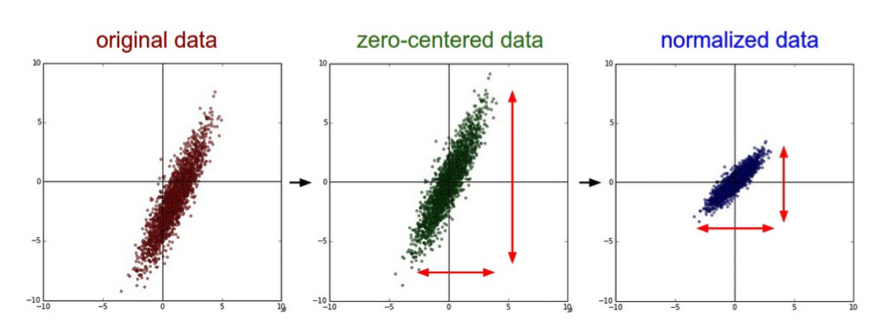

</div>

---
<div align="center">

### Scaling Methods Comparison

| **Method** | **Mathematical Formula** | **Python Implementation** | **When to Use / Notes** |
|------------|-------------------------|---------------------------|------------------------|
| **Standardization** (Z-score) | $$\mathbf{X}_{\text{scaled}} = \frac{\mathbf{X} - \boldsymbol{\mu}}{\boldsymbol{\sigma}}$$ where $\boldsymbol{\mu}$ = mean, $\boldsymbol{\sigma}$ = std dev | `from sklearn.preprocessing import StandardScaler` <br> `scaler = StandardScaler()` <br> `X_scaled = scaler.fit_transform(X)` | **Most common choice** <br> • Result: $\mu=0$, $\sigma=1$ <br> • Works well for Gaussian-like distributions <br> • Best for most neural networks |
| **Min-Max Normalization** | $$\mathbf{X}_{\text{scaled}} = \frac{\mathbf{X} - \mathbf{X}_{\min}}{\mathbf{X}_{\max} - \mathbf{X}_{\min}}$$ | `from sklearn.preprocessing import MinMaxScaler` <br> `scaler = MinMaxScaler()` <br> `X_scaled = scaler.fit_transform(X)` | **Bounded range needed** <br> • Result: Range $[0, 1]$ <br> • Good for image data (0-255 → 0-1) <br> ⚠️ **Sensitive to outliers** |
| **Robust Scaling** | $$\mathbf{X}_{\text{scaled}} = \frac{\mathbf{X} - \text{median}}{\text{IQR}}$$ where IQR = Q3 - Q1 | `from sklearn.preprocessing import RobustScaler` <br> `scaler = RobustScaler()` <br> `X_scaled = scaler.fit_transform(X)` | **Data has outliers** <br> • Uses median & IQR (robust statistics) <br> • Not affected by extreme values <br> • Result: Not strictly bounded |
| **Max Abs Scaling** | $$\mathbf{X}_{\text{scaled}} = \frac{\mathbf{X}}{\|\mathbf{X}\|_{\max}}$$ | `from sklearn.preprocessing import MaxAbsScaler` <br> `scaler = MaxAbsScaler()` <br> `X_scaled = scaler.fit_transform(X)` | **Sparse data** <br> • Result: Range $[-1, 1]$ <br> • Preserves sparsity (zeros stay zeros) <br> • No centering applied |

</div>

### Critical Reminder: Training vs Test Data

**Always fit scaler on training data only!**

```python
# ✓ CORRECT
scaler.fit(X_train)                    # Learn statistics from training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)   # Apply SAME transformation

# ✗ WRONG - Data leakage!
scaler.fit(X_test)                     # Never fit on test data!

## Data Whitening

**Given:** Zero-centered, scaled data $\mathbf{X}_{\text{scaled}}$ where features may be correlated

### Why Whiten?

**Key Benefit:** Removes correlations between features → makes features independent and equally weighted

**What happens WITHOUT whitening:**
- Correlated features carry redundant information
- Optimization must "learn" to decorrelate features during training
- Slower convergence due to dependencies between parameters
- Gradient descent inefficient in correlated feature space

### What is Whitening?

Whitening transforms data so that:
1. **Zero mean**: $\mathbb{E}[\mathbf{X}_{\text{white}}] = \mathbf{0}$
2. **Unit variance**: $\text{Var}[\mathbf{X}_{\text{white}}] = 1$
3. **Uncorrelated features**: Covariance matrix = Identity, i.e., $\text{Cov}[\mathbf{X}_{\text{white}}] = \mathbf{I}$


<div align="center">

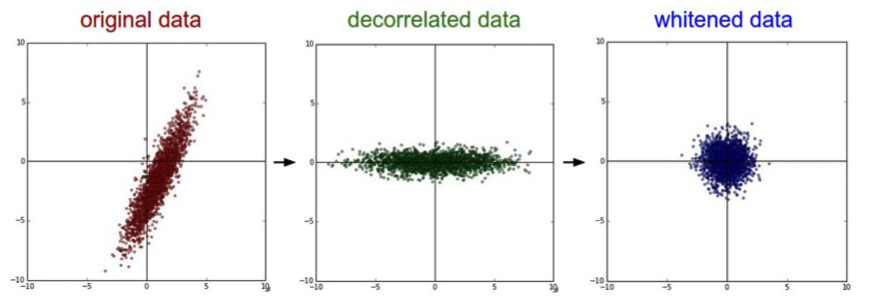

</div>



### Mathematical Formulation

**Step 1: Compute covariance matrix**
$$\mathbf{C} = \frac{1}{n}\mathbf{X}^T\mathbf{X}$$

**Step 2: Eigendecomposition**
$$\mathbf{C} = \mathbf{U}\mathbf{\Lambda}\mathbf{U}^T$$

where:
- $\mathbf{U}$ = eigenvectors (rotation matrix)
- $\mathbf{\Lambda}$ = diagonal matrix of eigenvalues

**Step 3: Whitening transformation**

#### **ZCA Whitening** (most common)
$$\mathbf{X}_{\text{white}} = \mathbf{U}\mathbf{\Lambda}^{-1/2}\mathbf{U}^T\mathbf{X}$$

- Preserves similarity to original data
- Minimal change in appearance (for images)

#### **PCA Whitening**
$$\mathbf{X}_{\text{white}} = \mathbf{\Lambda}^{-1/2}\mathbf{U}^T\mathbf{X}$$

- Rotates data to principal component axes first
- Changes appearance more drastically

### In Practice (Python)

```python
import numpy as np

def zca_whitening(X, epsilon=1e-5):
    """
    ZCA Whitening transformation
    X: (n_samples, n_features) - already zero-centered
    epsilon: small constant for numerical stability
    """
    # Covariance matrix
    cov = np.cov(X.T)
    
    # Eigendecomposition
    U, Lambda, _ = np.linalg.svd(cov)
    
    # ZCA whitening matrix
    W = U @ np.diag(1.0 / np.sqrt(Lambda + epsilon)) @ U.T
    
    # Apply whitening
    X_white = X @ W
    
    return X_white, W

# Usage
X_centered = X - X.mean(axis=0)
X_white, whitening_matrix = zca_whitening(X_centered)

# For test data: use same whitening matrix!
X_test_centered = X_test - X.mean(axis=0)  # Use TRAIN mean!
X_test_white = X_test_centered @ whitening_matrix

def pca_whitening(X, epsilon=1e-5):
    """
    PCA Whitening transformation
    """
    # Covariance matrix
    cov = np.cov(X.T)
    
    # Eigendecomposition
    U, Lambda, _ = np.linalg.svd(cov)
    
    # PCA whitening
    X_white = X @ U @ np.diag(1.0 / np.sqrt(Lambda + epsilon))
    
    return X_white

# Usage
X_white = pca_whitening(X_centered)

# Weight Initialization

We now address how to initialize the parameter before we start training. 

To understand the importance we'll shall use the following simple model structure.

$$\begin{align}f_k 
&= \beta_k + \Omega_k h_k \\
&= \beta_k + \Omega_k a[f_{k-1}]
\end{align}$$

Where $a[•]$ applies the $ReLU$ function and $\Omega_k \ \beta_k$ are the respective weights and biases. <br>
$\text{Let's see what happens if } \beta_k = 0 \text{ and } \Omega_k $ ~ $N(\mu=0, \sigma^2)$

We'll Consider two cases: 

1. The variance is very small:
   - We'll see that the the values we'll be very close together and very small in magnitude, this means these values won't sum to be too large (pre-activation). <br> When passed through the activation, this means that roughly half the parameters are clipped. This will have a ripple effect for the next pre-activation and so on and so forth.
   -  This is known as $\textcolor{lightblue}{Vanishing \ Gradient \ problem}$
2. The variance is very large
   - We'll see the weighths are going to be very large in magnitude and spread out, so by the linear function (pre-activation) lead to higher values.<br> The activation function will half these values (roughly) however, these values will still be large throughout the network.
   - This is known as $\textcolor{lightblue}{Exploding \ Gradient \ problem}$

**Conclusion**

The different scenarios can't be represented with finite prescision float arithmetic.

We now formalize the above notion

---



### Initialization for forward pass


Consider two adjacent layers with pre-activations: <br> $f \in \mathbb{R}^{D_\text{in}}$ and $f' \in \mathbb{R}^{D_\text{out}}$:
<br>
$
h = a(f) \in \mathbb{R}^{D_\text{in}}, \qquad f' = \beta + \Omega h, \qquad \Omega \in \mathbb{R}^{D_\text{out} \times D_\text{in}}
$
<br>
$
h = a[f] \\
f' = \beta + \Omega h
$

Assume:
- $f_j$ has variance $\sigma_f^2$
- $\beta_i = 0$
- $\Omega_{ij} \sim \mathcal{N}(0, \sigma_\Omega^2)$, independent of $h_j$

GOAL: derive expressions for $\mathbb{E}[f_{i}']$  and $\mathbb{E}[f_i'^{2}] - \mathbb{E}[f_i']^2$


**Expectation**

$$
\begin{align}
\mathbb{E}[f_{i}'] 
&= \mathbb{E}\left[\beta_i + \sum_{j=1}^{D_h} \Omega_{ij}h_j\right] \\
&= \mathbb{E}[\beta_i] + \sum_{j=1}^{D_h}\mathbb{E}\left[\Omega_{ij}h_j\right] \\
&= \mathbb{E}[\beta_i] + \sum_{j=1}^{D_h}\mathbb{E}\left[\Omega_{ij}\right]\mathbb{E}[h_j]\\
&= 0 + \sum_{j=1}^{D_h} 0 \cdot \mathbb{E}[h_j]
\end{align}
$$



**Variance**

$$
\begin{align}
\sigma_{f'}^2 
&= \mathbb{E}[f_i'^{2}] - \mathbb{E}[f_i']^2 \\ 
&= \mathbb{E}\left[ \left(\beta_i + \sum_{j=1}^{D_h}\Omega_{ij}h_j\right)^2 \right] - 0 \\
&= \mathbb{E}\left[ (\beta_i)^2 + 2\beta_i\sum_{j=1}^{D_h}\Omega_{ij}h_j + \left(\sum_{j=1}^{D_h}\Omega_{ij}h_j\right)^2 \right] \\
&= \mathbb{E}\left[\beta_i^2 \right] + 2\mathbb{E}\left[\beta_i\right]\left[\sum_{j=1}^{D_h}\Omega_{ij}h_j\right] + \mathbb{E}\left(\sum_{j=1}^{D_h}\Omega_{ij}h_j\right)^2 \\
&= 0 + 0 + \mathbb{E}\left(\sum_{j=1}^{D_h}\Omega_{ij}h_j\right)^2 \\
&= \sum_{j=1}^{D_h} \mathbb{E}\left[\Omega_{ij}^2\right]\mathbb{E}[h_j^2] \\ 
&= \sigma_{\Omega}^2 \sum_{j=1}^{D_h} \mathbb{E}[h_j^2]
\end{align}
$$


Assume now that the distribution of pre-actications $f_j$ at the previous layer is symmetric about zero,<br> this means that half of these pre-activations are clipped by the activation function and the second moment $\mathbb{E}[h_j^2]$ will be half of the variance $\sigma^2_f$ of $f_j$:

$$\boxed{\sigma_{f'_i}^2 = \sigma_{\Omega}^2 \sum_{j=1}^{D_h} \frac{\sigma^2_f}{2} = \frac{1}{2}D_h\sigma_{\Omega}^2\sigma^2_f}$$

**Tanh/Sigmoid**
Note that if the our activation function sigmoid or tanh then we assume $\mathbb{E}[h_j^2] \approx \sigma_f^2$

$$\boxed{\sigma_{f'_i}^2 = \sigma_{\Omega}^2 \sum_{j=1}^{D_h} \frac{\sigma^2_f}{2} = D_h\sigma_{\Omega}^2\sigma^2_f}$$

We see from this that variance diminishes as we move across the network, thus values are getting closer to zero, which could stop learning. 

To mitigate this effect we must **maintain constant variance** across layers by choosing $\sigma_{\Omega}^2$ appropriately.

### Solution: He Initialization (for ReLU)

To keep variance constant: $\sigma_{f'}^2 = \sigma_f^2$

From our derivation:
$$\sigma_{f'}^2 = \frac{1}{2}D_h\sigma_{\Omega}^2\sigma_f^2$$

Setting $\sigma_{f'}^2 = \sigma_f^2$:
$$\sigma_f^2 = \frac{1}{2}D_h\sigma_{\Omega}^2\sigma_f^2$$

Solving for $\sigma_{\Omega}^2$:
$$\boxed{\sigma_{\Omega}^2 = \frac{2}{D_h}}$$

**He Initialization Formula:**
$$\Omega_{ij} \sim \mathcal{N}\left(0, \frac{2}{D_h}\right)$$

where $D_h$ = number of input units to the layer (fan-in)


### In Practice (Python)

```python
import numpy as np
import torch.nn as nn

# NumPy
def he_init(shape):
    """
    He initialization for weights
    shape: (output_dim, input_dim)
    """
    fan_in = shape[1]  # number of input units
    std = np.sqrt(2.0 / fan_in)
    return np.random.normal(0, std, size=shape)

# Usage
weights = he_init((output_dim, input_dim))

# PyTorch (automatic)
layer = nn.Linear(input_dim, output_dim)
nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
# or
nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
```

---

### Initialization for Backward Pass

Consider two adjacent layers with pre-activations $f \in \mathbb{R}^{D_\text{in}}$ and $f' \in \mathbb{R}^{D_\text{out}}$, and weights $\Omega \in \mathbb{R}^{D_\text{out} \times D_\text{in}}$.

During backpropagation, the gradient with respect to the pre-activations is:
$$
\frac{\partial l}{\partial f} = a'[f] \odot \left( \Omega^T \frac{\partial l}{\partial f'} \right )
$$

Assume:
- $\frac{\partial l}{\partial f'_k}$ has variance $\sigma_{\text{grad}}^2$ and zero mean, for $k = 1, \ldots, D_\text{out}$
- $\Omega_{kj} \sim \mathcal{N}(0, \sigma_\Omega^2)$, independent of $\frac{\partial l}{\partial f'_k}$
- $a'[f_j]$ is the activation derivative (for ReLU, $a'[f_j] = 1$ with probability $1/2$, $0$ otherwise)

**GOAL:** Derive how $\mathbb{E}\left[\frac{\partial l}{\partial f_j}\right]$ and  $\mathbb{E}\left[\left [\frac{\partial l}{\partial f_j}\right]^2\right] - \mathbb{E} \left[\frac{\partial l}{\partial f_j}\right]^2$ evolves as gradients pass through each layer, in terms of $D_\text{in}$, $D_\text{out}$, and $\sigma_\Omega^2$.

**Expectation**

$$
\begin{align*}
\mathbb{E}\left[\frac{\partial l}{\partial f_j}\right] 
    &= \mathbb{E}\left[ a'[f_j] \sum_{i=1}^{D_\text{out}} \Omega_{ji} \frac{\partial l}{\partial f'_i} \right] \\\\
    % Linearity of expectation (sum)
    &\quad\textcolor{gray}{\text{(Linearity of expectation: move $\mathbb{E}$ inside the sum)}} \\\\
    &= \sum_{i=1}^{D_\text{out}} \mathbb{E}\left[ a'[f_j] \Omega_{ji} \frac{\partial l}{\partial f'_i} \right] \\\\
    % Independence of variables
    &\quad\textcolor{gray}{\text{(Independence: factor expectation of product into product of expectations)}} \\\\
    &= \mathbb{E}[a'[f_j]] \sum_{i=1}^{D_\text{out}} \mathbb{E}[ \Omega_{ji} ] \cdot \mathbb{E}\left[ \frac{\partial l}{\partial f'_i} \right] \\\\
    % Zero mean of weights and gradients
    &\quad\textcolor{gray}{\text{(Both $\mathbb{E}[\Omega_{ji}] = 0$ and $\mathbb{E}\left[ \frac{\partial l}{\partial f'_i} \right] = 0$)}} \\\\
    &= \mathbb{E}[a'[f_j]] \sum_{i=1}^{D_\text{out}} 0 \cdot 0 \\\\
    &= 0
\end{align*}
$$


**Variance**

$$
\begin{align*}
\text{Var}\left[\frac{\partial l}{\partial f_j}\right]
&= \mathbb{E}\left[\left [\frac{\partial l}{\partial f_j}\right]^2\right] - \mathbb{E} \left[\frac{\partial l}{\partial f_j}\right]^2 \\\\
&= \mathbb{E}\left[\left [\frac{\partial l}{\partial f_j}\right]^2\right] \\\\
&= \mathbb{E}\left[ \left(a'[f_j] \sum_{i=1}^{D_\text{out}} \Omega_{ji} \frac{\partial l}{\partial f'_i}\right)^2 \right] \\\\
&= \mathbb{E}\left[\left(a'[f_j]\right)^2 \left(\sum_{i=1}^{D_\text{out}} \Omega_{ji} \frac{\partial l}{\partial f'_i}\right)^2 \right] \\\\
&= \mathbb{E}\left[\left(a'[f_j]\right)^2\right] \cdot \mathbb{E} \left[\left(\sum_{i=1}^{D_\text{out}} \Omega_{ji} \frac{\partial l}{\partial f'_i}\right)^2 \right] \\\\
&= \mathbb{E}\left[\left(a'[f_j]\right)^2\right] \cdot \sum_{i=1}^{D_\text{out}} \mathbb{E} \left[ \Omega_{ji}^2 \right] \cdot \mathbb{E} \left [\left (\frac{\partial l}{\partial f'_i}\right)^2 \right] \\\\
&= \mathbb{E}\left[\left(a'[f_j]\right)^2\right] \cdot D_\text{out} \cdot \sigma_{\Omega}^2 \cdot \sigma_{\text{grad}}^2
\end{align*}
$$

The value of $\mathbb{E}\left[\left(a'[f_j]\right)^2\right]$ depends on the activation function:
$$
\mathbb{E}\left[\left(a'[f_j]\right)^2\right] =
\begin{cases}
    \frac{1}{2} & \text{if $a$ is ReLU} \\\\
    1           & \text{if $a$ is linear, tanh, or sigmoid}
\end{cases}
$$

So, the variance is:
$$
\text{Var}\left[\frac{\partial l}{\partial f_j}\right] =
\begin{cases}
    \frac{1}{2} D_\text{out} \sigma_{\Omega}^2 \sigma_{\text{grad}}^2 & \text{(ReLU)} \\\\
    D_\text{out} \sigma_{\Omega}^2 \sigma_{\text{grad}}^2 & \text{(tanh, sigmoid, linear)}
\end{cases}
$$

---

### The Problem: Forward vs Backward Pass Conflict

**From forward pass:** We need $\sigma_{\Omega}^2 = \frac{2}{D_\text{in}}$ (fan-in)

**From backward pass:** We need $\sigma_{\Omega}^2 = \frac{2}{D_\text{out}}$ (fan-out)

**Conflict:** Unless $D_\text{in} = D_\text{out}$ (all layers same size), we can't satisfy both!



---

### Solution: Xavier/Glorot Initialization (Compromise)

**Idea:** Average the fan-in and fan-out requirements:

$$\sigma_{\Omega}^2 = \frac{2}{D_h + D_{h'}}$$

This is called **Xavier initialization** (or Glorot initialization).

**Alternative formulations:**

1. **Harmonic mean:**
   $$\sigma_{\Omega}^2 = \frac{2}{\frac{D_h + D_{h'}}{2}} = \frac{4}{D_h + D_{h'}}$$

2. **For tanh/sigmoid (no ReLU clipping):**
   $$\sigma_{\Omega}^2 = \frac{1}{D_h + D_{h'}}$$
   (Remove factor of 2 since no clipping occurs)

---

### Practical Initialization Strategies

| **Activation** | **Method** | **Variance Formula** | **Mode** |
|---------------|-----------|---------------------|----------|
| ReLU | He (forward) | $\sigma_{\Omega}^2 = \frac{2}{D_h}$ | `fan_in` |
| ReLU | He (backward) | $\sigma_{\Omega}^2 = \frac{2}{D_{h'}}$ | `fan_out` |
| ReLU | Xavier | $\sigma_{\Omega}^2 = \frac{2}{D_h + D_{h'}}$ | `fan_avg` |
| tanh/sigmoid | Xavier | $\sigma_{\Omega}^2 = \frac{1}{D_h + D_{h'}}$ | `fan_avg` |

---

### In Practice (Python)

```python
import torch.nn as nn

# He initialization (fan_in) - most common for ReLU
layer = nn.Linear(input_dim, output_dim)
nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

# He initialization (fan_out) - for backward pass stability
nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')

# Xavier/Glorot initialization - for tanh/sigmoid
nn.init.xavier_normal_(layer.weight, gain=1.0)

# Xavier with uniform distribution
nn.init.xavier_uniform_(layer.weight, gain=1.0)

# Activation Functions

Activation functions introduce non-linearity into neural networks, enabling them to learn complex patterns.<br> The choice of activation function significantly impacts training dynamics and model performance.




## 1. Sigmoid Function

### Definition

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

**Derivative:**
$$\sigma'(x) = \sigma(x)(1 - \sigma(x))$$

**Range:** $(0, 1)$

**Shape:** S-shaped curve

<div align="center">



| **✅ Advantages** | **❌ Disadvantages** |
|------------------|---------------------|
| **Probabilistic interpretation**: Output in $(0, 1)$ → natural for binary classification | **Vanishing gradients**: For $\|x\| > 4$, gradient $\approx 0$ → slow/no learning in deep networks <br> $\sigma'(x)_{\text{max}} = 0.25$ → gradients shrink by 75% per layer! |
| **Smooth gradient**: Differentiable everywhere | **Not zero-centered**: Outputs always positive → gradients always same sign → zig-zagging during optimization |
| **Output interpretation**: Can be interpreted as probabilities | **Computationally expensive**: Exponential calculation slower than simpler functions |
| **Historical importance**: One of the first activation functions used | **Saturation**: Neurons can get "stuck" in saturated regions (flat parts of curve) |



### Things to Consider for Good Training

| **Consideration** | **Solution** |
|------------------|-------------|
| **Vanishing gradients** | Use only in output layer for binary classification |
| **Not zero-centered** | Apply batch normalization before sigmoid |
| **Weight initialization** | Use Xavier initialization: $\sigma_{\Omega}^2 = \frac{1}{D_h + D_{h'}}$ |
| **Deep networks** | Avoid in hidden layers; use ReLU instead |
| **Learning rate** | May need smaller learning rate to prevent saturation |

**Best use case:** **Output layer for binary classification** (with BCE loss)

```python
# PyTorch usage
import torch.nn as nn

# Output layer for binary classification
output = nn.Sigmoid()

# Better: Use BCEWithLogitsLoss (combines sigmoid + BCE, more numerically stable)
criterion = nn.BCEWithLogitsLoss()  # Don't add sigmoid to model!

## 2. Tanh (Hyperbolic Tangent)

### Definition

$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{2}{1 + e^{-2x}} - 1$$

**Derivative:**
$$\tanh'(x) = 1 - \tanh^2(x)$$

**Range:** $(-1, 1)$

**Shape:** S-shaped curve (zero-centered)

---


| **✅ Advantages** | **❌ Disadvantages** |
|------------------|---------------------|
| **Zero-centered**: Output in $(-1, 1)$ → better gradient flow than sigmoid | **Vanishing gradients**: For $\|x\| > 3$, gradient $\approx 0$ → problem persists in very deep networks |
| **Stronger gradients**: $\tanh'(x)_{\text{max}} = 1$ (4× stronger than sigmoid!) | **Computationally expensive**: Still requires exponential calculations |
| **Symmetric**: Easier optimization, less bias in weight updates | **Saturation**: Can still saturate at extremes ($\pm 1$) |
| **Smooth and differentiable**: Good gradient properties everywhere | **Not ideal for deep networks**: ReLU typically performs better |

---

### Things to Consider for Good Training

| **Consideration** | **Solution** |
|------------------|-------------|
| **Vanishing gradients** | Use in shallow networks or with residual connections |
| **Weight initialization** | Use Xavier initialization: $\sigma_{\Omega}^2 = \frac{1}{D_h + D_{h'}}$ |
| **Deep networks** | Prefer ReLU for hidden layers in deep networks |
| **Input normalization** | Zero-center and scale inputs to avoid saturation |
| **Gradient clipping** | Clip gradients to prevent explosion (especially in RNNs) |

**Best use case:** **RNNs/LSTMs** (historically) and **shallow networks**

```python
# PyTorch usage
import torch.nn as nn

# Hidden layer with tanh
layer = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.Tanh()
)

# Initialize weights properly
nn.init.xavier_normal_(layer[0].weight)

# RNNs/LSTMs use tanh internally
lstm = nn.LSTM(input_size, hidden_size)  # tanh is built-in
```

## 3. ReLU (Rectified Linear Unit)

### Definition

$$\text{ReLU}(x) = \max(0, x) = \begin{cases} x & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases}$$

**Derivative:**
$$\text{ReLU}'(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases}$$

**Range:** $[0, \infty)$

**Shape:** Piecewise linear

---


| **✅ Advantages** | **❌ Disadvantages** |
|------------------|---------------------|
| **No vanishing gradient (for $x > 0$)**: Gradient = 1 → no gradient shrinkage during backprop → enables training of very deep networks | **Dying ReLU problem**: If neuron outputs negative pre-activation, gradient = 0 forever → neuron "dies" and never recovers <br> Can happen with large learning rates or poor initialization |
| **Computationally efficient**: Simple thresholding at zero (no exponentials!) → ~6× faster than sigmoid/tanh | **Not zero-centered**: Output always $\geq 0$ → same gradient sign issue as sigmoid <br> Less problematic than sigmoid due to sparsity |
| **Sparsity**: Outputs exactly zero for negative inputs → natural sparsity can improve performance and interpretability | **Unbounded**: Can lead to exploding activations if not controlled → needs proper initialization and normalization |
| **Better convergence**: Empirically converges faster than sigmoid/tanh | **Not differentiable at zero**: In practice, define $\text{ReLU}'(0) = 0$ (or 0.5) |
| **Biologically plausible**: Similar to neural firing patterns in brain | |

---

### Things to Consider for Good Training

| **Consideration** | **Solution** |
|------------------|-------------|
| **Dying ReLU** | • Use **Leaky ReLU** or **ELU** variants <br> • Use smaller learning rate <br> • Use **He initialization** |
| **Weight initialization** | **He initialization**: $\sigma_{\Omega}^2 = \frac{2}{D_h}$ (accounts for ReLU clipping) |
| **Exploding activations** | • Use batch normalization <br> • Use layer normalization <br> • Gradient clipping |
| **Not zero-centered** | • Apply batch normalization <br> • Use PReLU/ELU variants |
| **Bias initialization** | Initialize biases to small positive values (e.g., 0.01) to avoid dead neurons |

**Best use case:** **Default choice for hidden layers in deep networks** (CNNs, ResNets, Transformers)

```python
# PyTorch usage
import torch.nn as nn

# Hidden layer with ReLU
layer = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU()
)

# Initialize with He initialization
nn.init.kaiming_normal_(layer[0].weight, mode='fan_in', nonlinearity='relu')
nn.init.constant_(layer[0].bias, 0.01)  # Small positive bias

# Better: Use inplace operation for memory efficiency
layer = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(inplace=True)  # Saves memory
)
```

---

### ReLU Variants (Brief Overview)

**Leaky ReLU:**
$$\text{LeakyReLU}(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha x & \text{if } x \leq 0 \end{cases}, \quad \alpha = 0.01$$

**Advantage:** Prevents dying ReLU (small gradient for negative inputs)

```python
nn.LeakyReLU(negative_slope=0.01)
```

**Parametric ReLU (PReLU):**
$$\text{PReLU}(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha x & \text{if } x \leq 0 \end{cases}$$

**Advantage:** $\alpha$ is **learned** during training

```python
nn.PReLU()
```

**ELU (Exponential Linear Unit):**
$$\text{ELU}(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha(e^x - 1) & \text{if } x \leq 0 \end{cases}$$

**Advantage:** Smooth, zero-centered mean, reduces bias shift

```python
nn.ELU(alpha=1.0)
```

**GELU (Gaussian Error Linear Unit):**
$$\text{GELU}(x) = x \cdot \Phi(x)$$

where $\Phi(x)$ is the Gaussian CDF

**Advantage:** Smooth, stochastic regularization, used in **Transformers** (BERT, GPT)

```python
nn.GELU()
```